## <center> <font color='purple'> Dynamic Ensemble Machine Learning Models (Mix Pool)</font></center> 
#### <center>Firuz Juraev (Sungkyunkwan Unniversity)</center>

### <font color='green'> Libraries 

#### <font color='blue'> Basic Libraries 

In [29]:
import pandas as pd
import numpy as np 
from numpy import mean
from numpy import std
import seaborn as sns 
import random
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

#### <font color='blue'> Single ML Models Libraries 

In [2]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

#### <font color='blue'> Static ML Models Libraries 

In [3]:
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

#### <font color='blue'> DES Libraries 

In [4]:
from deslib.des import DESP
from deslib.des import KNORAE
from deslib.des import KNORAU
from deslib.des import METADES
from deslib.des import DESKNN # new 
from deslib.des import KNOP # new 

#### <font color='blue'> DCS Libraries 

In [5]:
from deslib.dcs import MCB

#### <font color='blue'> Processing Libraries 

In [6]:
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

from sklearn.metrics import (accuracy_score,
                             precision_score,
                             recall_score, 
                             f1_score,
                             roc_auc_score, 
                             auc)
from sklearn.metrics import roc_curve, roc_auc_score 
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

#### <font color='blue'>Libraries for Critical Diagram 

In [37]:
from sklearn.model_selection import StratifiedKFold
from scipy.stats import wilcoxon, friedmanchisquare, rankdata
from Orange.evaluation import compute_CD, graph_ranks
from sklearn.metrics import mean_absolute_error

### <font color='green'> Load Dataset 

In [7]:
train_dataset_upsampled = pd.read_csv("Data/Resampled_neonates_train_data_4.csv")
test_dataset_upsampled = pd.read_csv("Data/Resampled_neonates_test_data_4.csv")

X_train = train_dataset_upsampled.drop(["DEAD"], axis=1) 
y_train = train_dataset_upsampled["DEAD"]

X_test = test_dataset_upsampled.drop(["DEAD"], axis=1) 
y_test = test_dataset_upsampled["DEAD"]

In [8]:
columns = X_train.columns.to_list()

### <font color='green'> Data Normalization

In [9]:
Min_max_scaler = MinMaxScaler().fit(X_train)

## Scaling 
X_train_mm_scaled = Min_max_scaler.transform(X_train)
X_test_mm_scaled = Min_max_scaler.transform(X_test)

## Numpy Array to DataFrame 
df_train_mm_scaled = pd.DataFrame(X_train_mm_scaled, columns = columns)
df_test_mm_scaled = pd.DataFrame(X_test_mm_scaled, columns = columns)

### <font color='green'> Feature Selection

In [10]:
tain_mm_scaled_df = df_train_mm_scaled[:]
tain_mm_scaled_df["DEAD"] = y_train 

test_mm_scaled_df = df_test_mm_scaled[:] 
test_mm_scaled_df["DEAD"] = y_test


importances = mutual_info_classif(df_train_mm_scaled, y_train)
feat_importance = pd.Series(importances, tain_mm_scaled_df.columns[0:len(tain_mm_scaled_df.columns)-1])
    
feat_importance = feat_importance.sort_values(ascending=False)
    
selected_features = feat_importance[:30]
selected_features_list_mm_scaled = selected_features.index.to_list()


tain_mm_scaled_df[selected_features_list_mm_scaled].head(2)

,temperature_mean,respRate_std,respRate_var,skinTemperature_std,skinTemperature_var,heartRate_std,heartRate_var,bpCuffMean_var,sao2_var,sao2_std,...,bpCuffDiastolic_mean,BIRTH_WEIGHT,bpCuffSystolic_mean,temperature_var,temperature_std,glucometer_mean,sao2_mean,bpCuffMean_mean,PLATELET,D10W_SUM
0,0.775318,0.422245,0.178291,0.134078,0.017977,0.22911,0.057937,0.053294,0.009568,0.097817,...,0.457143,0.264267,0.602649,0.015695,0.125281,0.312593,0.881455,0.310696,0.281330,0.156019
1,0.709668,0.583964,0.341014,0.086672,0.007512,0.28258,0.086102,0.020317,0.006551,0.080938,...,0.479330,0.437819,0.644907,0.003770,0.061399,0.272551,0.926056,0.351928,0.392157,0.211970


In [11]:
X_train_mm = df_train_mm_scaled[selected_features_list_mm_scaled][:]
X_test_mm = df_test_mm_scaled[selected_features_list_mm_scaled][:]

### <font color='purple'> Hold-out Test (With Mix ML) - (+FS, +HO)

In [12]:
def get_individual_result(model, dsel_x, dsel_y, test_x, test_y): 
    model.fit(dsel_x, dsel_y)
    y_preds = model.predict(test_x) 
    yproba = model.predict_proba(test_x)[::,1] 
    
    acc = accuracy_score(test_y, y_preds)
    prec = precision_score(test_y, y_preds)
    rec = recall_score(test_y, y_preds)
    f1 = f1_score(test_y, y_preds)
    fpr, tpr, _ = roc_curve(test_y,  yproba) 
    auc = roc_auc_score(test_y, yproba)
    
    return {"acc": acc, "prec": prec, "rec": rec, "f1":f1, "fpr": fpr, "tpr":tpr, "auc": auc}
    

In [13]:
def hold_out_mix_ML(): 
    rng = np.random.RandomState(42) 
    X_train, X_dsel, y_train_en, y_dsel = train_test_split(X_train_mm, y_train, test_size=0.40, random_state=rng)
    
    model_svc = SVC(kernel='linear', C=0.007, gamma=0.2, degree=3, probability=True, class_weight='balanced')
    model_dt = DecisionTreeClassifier(criterion='entropy', max_depth=3) # depth was 3  
    model_lr = LogisticRegression(penalty='l2', C=0.002)
    model_ml_perceptron = MLPClassifier(solver='adam', max_iter=11, verbose=10,learning_rate_init=.003)
    model_rf  = RandomForestClassifier(criterion='gini', n_estimators=100, max_depth=3)
    model_cat = MLPClassifier(solver='adam', max_iter=11, verbose=10,learning_rate_init=.003)
    model_lgb = LGBMClassifier(max_depth=1, n_estimators=150, objective="binary")
#     model_ada = AdaBoostClassifier(n_estimators=250, learning_rate=0.01)
    
    model_svc.fit(X_train, y_train_en)
    model_dt.fit(X_train, y_train_en)
    model_lr.fit(X_train, y_train_en)
    model_ml_perceptron.fit(X_train, y_train_en)
    model_rf.fit(X_train, y_train_en) 
    model_cat.fit(X_train, y_train_en) 
    model_lgb.fit(X_train, y_train_en)
#     model_ada.fit(X_train, y_train_en)
    
    classifiers_names = ["MLP", "Decision Tree", "Logistic Regression", "SVC", "Random Forest", 
                         "CatBoost", "LGBM"] # "Decision Tree",
    # "AdaBoost" , "LGBM"
    pool_classifiers = [model_ml_perceptron, 
                        model_dt,
                        model_lr, 
                        model_svc, 
                        model_rf, 
                        model_cat,
                        model_lgb, 
                        ] # model_ada
    c_acc_list = [] 
    
    for cls in pool_classifiers:
        y_preds_c = cls.predict(X_test_mm) 
        c_acc_list.append(accuracy_score(y_test, y_preds_c))           
        
        
    classifiers_results =  {'name': classifiers_names, 
                            'accuracy': c_acc_list}
    
    clsDF = pd.DataFrame.from_dict(classifiers_results)
        
    # DES STARTS
    
    knorau = KNORAU(pool_classifiers)
    kne = KNORAE(pool_classifiers)  
    metades = METADES(pool_classifiers)
    desknn = DESKNN(pool_classifiers)
    mcb = MCB(pool_classifiers)
    desp = DESP(pool_classifiers)
    knop = KNOP(pool_classifiers)

    fire_knorau = KNORAU(pool_classifiers, DFP=True, k=7) 
    fire_kne = KNORAE(pool_classifiers, DFP=True, k=9)
    fire_metades = METADES(pool_classifiers, DFP=True, k=9) 
    fire_desknn = DESKNN(pool_classifiers, DFP=True, k=9)
    fire_mcb = MCB(pool_classifiers, DFP=True, k=7) # 7 was 96%
    fire_desp = DESP(pool_classifiers, DFP=True, k=9)
    fire_knop = KNOP(pool_classifiers, DFP=True, k=15)
    
    ensemble_classifiers = [fire_knorau, knorau, fire_kne, kne, fire_metades, metades, fire_desknn, desknn, 
                            fire_mcb, mcb, fire_desp, desp, fire_knop, knop]
    
    ensemble_names = ["FIRE-KNORA-U", "KNORA-U", "FIRE-KNORA-E", "KNORA-E", "FIRE-METADES", "METADES",
                      "FIRE-DESKNN", "DESKNN", "FIRE-MCB", "MCB", "FIRE-DESP", "DESP", "FIRE-KNOP", "KNOP"]
    
    acc_list = [] 
    precision_list = [] 
    recall_list = []
    f1_lists = [] 
    auc_list = [] 
    fpr_list = [] 
    tpr_list = []
    
    for e_cls in ensemble_classifiers:
        results_dct = get_individual_result(e_cls, X_dsel, y_dsel, X_test_mm, y_test)
        acc_list.append(results_dct["acc"])
        precision_list.append(results_dct["prec"])
        recall_list.append(results_dct["rec"]) 
        f1_lists.append(results_dct["f1"]) 
        auc_list.append(results_dct["auc"])
        fpr_list.append(results_dct["fpr"])
        tpr_list.append(results_dct["tpr"])

    
    results =  {'name': ensemble_names, 
                'accuracy': acc_list, 
                'precision': precision_list, 
                'recall': recall_list, 'f1': f1_lists, 
                'auc': auc_list, 
                'tpr': tpr_list, 'fpr': fpr_list}
    
    df = pd.DataFrame.from_dict(results)
    
    return df, clsDF

In [14]:
results_data = []
classifier_results_data = []
for i in range(0, 15):
    result, cls_results = hold_out_mix_ML()
    results_data.append(result)
    classifier_results_data.append(cls_results)
    

fireResultsDF = pd.concat(results_data)
classifiersResultsDF = pd.concat(classifier_results_data)

Iteration 1, loss = 0.64795275
Iteration 2, loss = 0.54079802
Iteration 3, loss = 0.45409933
Iteration 4, loss = 0.39738067
Iteration 5, loss = 0.36275339
Iteration 6, loss = 0.34437081
Iteration 7, loss = 0.32764064
Iteration 8, loss = 0.31368574
Iteration 9, loss = 0.30370870
Iteration 10, loss = 0.29334568
Iteration 11, loss = 0.28590409
Iteration 1, loss = 0.64432669
Iteration 2, loss = 0.53554740
Iteration 3, loss = 0.44919294
Iteration 4, loss = 0.39564676
Iteration 5, loss = 0.36616050
Iteration 6, loss = 0.34483183
Iteration 7, loss = 0.32864768
Iteration 8, loss = 0.31526271
Iteration 9, loss = 0.30272602
Iteration 10, loss = 0.29324472
Iteration 11, loss = 0.28304665
Iteration 1, loss = 0.62252048
Iteration 2, loss = 0.51231916
Iteration 3, loss = 0.43371680
Iteration 4, loss = 0.38390188
Iteration 5, loss = 0.35567914
Iteration 6, loss = 0.33422731
Iteration 7, loss = 0.31958334
Iteration 8, loss = 0.30643580
Iteration 9, loss = 0.29991020
Iteration 10, loss = 0.28763567
Ite

Iteration 1, loss = 0.64023650
Iteration 2, loss = 0.51837880
Iteration 3, loss = 0.42571350
Iteration 4, loss = 0.37938747
Iteration 5, loss = 0.35167645
Iteration 6, loss = 0.33052544
Iteration 7, loss = 0.31901809
Iteration 8, loss = 0.30419589
Iteration 9, loss = 0.29366734
Iteration 10, loss = 0.28530607
Iteration 11, loss = 0.27693021
Iteration 1, loss = 0.60504943
Iteration 2, loss = 0.49205924
Iteration 3, loss = 0.41868707
Iteration 4, loss = 0.37629236
Iteration 5, loss = 0.35087819
Iteration 6, loss = 0.33235303
Iteration 7, loss = 0.31896487
Iteration 8, loss = 0.30438955
Iteration 9, loss = 0.29414241
Iteration 10, loss = 0.28470953
Iteration 11, loss = 0.27733664
Iteration 1, loss = 0.62524586
Iteration 2, loss = 0.51159855
Iteration 3, loss = 0.43167507
Iteration 4, loss = 0.38300846
Iteration 5, loss = 0.35824078
Iteration 6, loss = 0.34232497
Iteration 7, loss = 0.33038515
Iteration 8, loss = 0.31765174
Iteration 9, loss = 0.30960234
Iteration 10, loss = 0.29746986
Ite

In [15]:
# fireResultsDF.to_csv("Results/des_mix_pool_7_cls_results_extend.csv", index=False)

In [16]:
ensemble_names = ["FIRE-KNORA-U", "KNORA-U", "FIRE-KNORA-E", "KNORA-E", "FIRE-METADES", "METADES",
                  "FIRE-DESKNN", "DESKNN", "FIRE-MCB", "MCB", "FIRE-DESP", "DESP", "FIRE-KNOP", "KNOP"]

accuracy = [] 
accuracy_std =  [] 
precision = [] 
precision_std = [] 
recall = [] 
recall_std = [] 
f1_score = [] 
f1_std = []
auc_score = []
auc_std = []


for n in ensemble_names:
    accuracy.append(round(fireResultsDF[fireResultsDF.name == n].accuracy.mean(), 3))
    accuracy_std.append(round(fireResultsDF[fireResultsDF.name == n].accuracy.std(), 3))
    precision.append(round(fireResultsDF[fireResultsDF.name == n].precision.mean(), 3))
    precision_std.append(round(fireResultsDF[fireResultsDF.name == n].precision.std(), 3))
    recall.append(round(fireResultsDF[fireResultsDF.name == n].recall.mean(), 3))
    recall_std.append(round(fireResultsDF[fireResultsDF.name == n].recall.std(), 3))
    f1_score.append(round(fireResultsDF[fireResultsDF.name == n].f1.mean(), 3))
    f1_std.append(round(fireResultsDF[fireResultsDF.name == n].f1.std(), 3))
    auc_score.append(round(fireResultsDF[fireResultsDF.name == n].auc.mean(), 3))
    auc_std.append(round(fireResultsDF[fireResultsDF.name == n].auc.std(), 3))
    
final_results = {"method": ensemble_names, 
                     "accuracy": accuracy, 
                     "accuracy_std": accuracy_std,
                     "precision": precision, 
                     "precision_std": precision_std,
                     "recall": recall, 
                     "recall_std": recall_std,
                     "f1_score": f1_score, 
                     "f1_std": f1_std, 
                     "auc": auc_score, 
                     "auc_std": auc_std}

finalResultsDF = pd.DataFrame.from_dict(final_results)

In [17]:
finalResultsDF

,method,accuracy,accuracy_std,precision,precision_std,recall,recall_std,f1_score,f1_std,auc,auc_std
0,FIRE-KNORA-U,0.972,0.001,0.948,0.002,1.000,0.000,0.973,0.001,0.990,0.001
1,KNORA-U,0.970,0.001,0.944,0.002,1.000,0.000,0.971,0.001,0.988,0.000
2,FIRE-KNORA-E,0.980,0.001,0.962,0.001,1.000,0.000,0.980,0.001,0.988,0.001
3,KNORA-E,0.980,0.001,0.961,0.002,1.000,0.000,0.980,0.001,0.988,0.001
4,FIRE-METADES,0.959,0.023,0.963,0.004,0.954,0.045,0.958,0.024,0.982,0.008
5,METADES,0.958,0.023,0.962,0.004,0.954,0.045,0.958,0.024,0.977,0.014
6,FIRE-DESKNN,0.975,0.001,0.953,0.003,1.000,0.000,0.976,0.001,0.986,0.001
7,DESKNN,0.975,0.001,0.952,0.003,1.000,0.000,0.975,0.001,0.986,0.001
8,FIRE-MCB,0.958,0.004,0.954,0.004,0.963,0.007,0.958,0.004,0.973,0.003
9,MCB,0.958,0.003,0.954,0.003,0.962,0.005,0.958,0.003,0.974,0.003


In [32]:
finalResultsDF.to_csv("Results/mix_pool_results/des_mix_pool_7_cls_results.csv", index=False)

In [19]:
classifiers_names = ["MLP", "Decision Tree", "Logistic Regression", "SVC", "Random Forest", "CatBoost", "LGBM"] 
# "AdaBoost", "LGBM"

accuracy_list = []
accuracy_std_list = []
for n in classifiers_names:
    accuracy_list.append(classifiersResultsDF[classifiersResultsDF.name == n].accuracy.mean())
    accuracy_std_list.append(classifiersResultsDF[classifiersResultsDF.name == n].accuracy.std())

final_cls_results = {"classifier": classifiers_names, 
                     "accuracy": accuracy_list, 
                     "accuracy_std": accuracy_std_list}

finalClassifierResultsDF = pd.DataFrame.from_dict(final_cls_results)

In [20]:
finalClassifierResultsDF

,classifier,accuracy,accuracy_std
0,MLP,0.945703,8.017512e-03
1,Decision Tree,0.930636,2.735127e-04
2,Logistic Regression,0.943366,4.596760e-16
3,SVC,0.932578,0.000000e+00
4,Random Forest,0.940201,2.402372e-03
5,CatBoost,0.943006,1.535312e-02
6,LGBM,0.935275,2.298380e-16


In [21]:
finalResultsDF.describe().T

,count,mean,std,min,25%,50%,75%,max
accuracy,14.0,0.966286,0.011027,0.943,0.95800,0.9710,0.97450,0.980
accuracy_std,14.0,0.006714,0.009051,0.001,0.00100,0.0010,0.00925,0.023
precision,14.0,0.955286,0.006966,0.944,0.94900,0.9540,0.96175,0.965
precision_std,14.0,0.002643,0.000929,0.001,0.00200,0.0025,0.00300,0.004
recall,14.0,0.978571,0.027570,0.919,0.95600,1.0000,1.00000,1.000
recall_std,14.0,0.012000,0.018663,0.000,0.00000,0.0000,0.01825,0.045
f1_score,14.0,0.966429,0.011547,0.942,0.95800,0.9720,0.97475,0.980
f1_std,14.0,0.007000,0.009495,0.001,0.00100,0.0010,0.01000,0.024
auc,14.0,0.983571,0.005774,0.973,0.97975,0.9860,0.98800,0.990
auc_std,14.0,0.002571,0.003877,0.000,0.00100,0.0010,0.00275,0.014


### <font color='purple'> ROC Curve 

In [23]:
fireResultsDF.head()

,name,accuracy,precision,recall,f1,auc,tpr,fpr
0,FIRE-KNORA-U,0.973571,0.949795,1.0,0.974251,0.990233,"[0.0, 0.06580366774541532, 0.06580366774541532...","[0.0, 0.0, 0.0010787486515641855, 0.0010787486..."
1,KNORA-U,0.971953,0.946885,1.0,0.972718,0.988507,"[0.0, 0.0, 0.06580366774541532, 0.065803667745...","[0.0, 0.0010787486515641855, 0.001078748651564..."
2,FIRE-KNORA-E,0.980583,0.962617,1.0,0.980952,0.987682,"[0.0, 0.0, 0.0, 0.07011866235167206, 0.1337648...","[0.0, 0.0010787486515641855, 0.003236245954692..."
3,KNORA-E,0.981661,0.964620,1.0,0.981992,0.987845,"[0.0, 0.0, 0.0, 0.07011866235167206, 0.1337648...","[0.0, 0.0010787486515641855, 0.003236245954692..."
4,FIRE-METADES,0.981122,0.963617,1.0,0.981472,0.986549,"[0.0, 0.0, 0.07011866235167206, 0.133764832793...","[0.0, 0.0010787486515641855, 0.001078748651564..."


In [24]:
names = ["FIRE-KNORA-U", "KNORA-U", "FIRE-KNORA-E", "KNORA-E", "FIRE-METADES", "METADES",
         "FIRE-DESKNN", "DESKNN", "FIRE-MCB", "MCB", "FIRE-DESP", "DESP", "FIRE-KNOP", "KNOP"]

fpr_lists = []
tpr_lists = []

for n in names: 
    fpr_lists.append(fireResultsDF[fireResultsDF.name==n].fpr.to_list())
    tpr_lists.append(fireResultsDF[fireResultsDF.name==n].tpr.to_list())

In [25]:
fpr_lists = []
tpr_lists = []

for n in names: 
    fpr_lists.append(fireResultsDF[fireResultsDF.name==n].fpr.to_list())
    tpr_lists.append(fireResultsDF[fireResultsDF.name==n].tpr.to_list())

In [26]:
def Extract(lst):
    return [item[7] for item in lst]

In [27]:
fpr_results = Extract(fpr_lists)
tpr_results = Extract(tpr_lists)

In [28]:
names = ["FIRE-KNORA-U", "KNORA-U", "FIRE-KNORA-E", "KNORA-E", "FIRE-METADES", "METADES",
         "FIRE-DESKNN", "DESKNN", "FIRE-MCB", "MCB", "FIRE-DESP", "DESP", "FIRE-KNOP", "KNOP"]


roc_results = {"models": names, 
              "auc": finalResultsDF.auc.to_list(), 
              "fpr": fpr_results, 
              "tpr": tpr_results}

res = pd.DataFrame.from_dict(roc_results)

res.set_index('models', inplace=True)

In [33]:
res.to_csv("Results/mix_pool_results/des_mix_pool_results_7_table_for_ROC.csv", index=False)

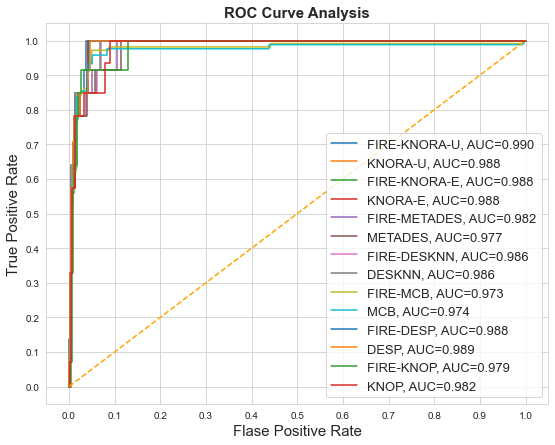

In [30]:
fig = plt.figure(figsize=(9,7))
sns.set_style("whitegrid")
for i in res.index:
    plt.plot(res.loc[i]['fpr'], 
             res.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, res.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

### <font color='purple'> Critical Diagram 

In [34]:
def compare_results(results, lst_models):      
        fried_result = friedmanchisquare(*results)
        
        ranks = np.array([rankdata(-p) for p in results])
        
        # Calculating the average ranks.
        average_ranks = np.mean(ranks, axis=0)

        names = [lst_models[i] + ' - ' + str(round(average_ranks[i], 3)) for i in range(len(average_ranks))]
        
        # This method computes the critical difference for Nemenyi test with alpha=0.1.
        # For some reason, this method only accepts alpha='0.05' or alpha='0.1'.
        cd = compute_CD(average_ranks, n=len(results),alpha='0.05', test='nemenyi')
        
        return fried_result, ranks, names, cd, average_ranks

In [35]:
def plot_comparisons(fried_result, names, cd, average_ranks):    
    # This method generates the plot.
    graph_ranks(average_ranks, names=names,
                        cd=cd, width=10, textspace=1.5)
        
    plt.title(f'Friedman-Nemenyi={round(fried_result.pvalue, 4)}\nCD={round(cd, 3)}')
    plt.show()
    
    return

In [38]:
names = ["FIRE-KNORA-U", "KNORA-U", "FIRE-KNORA-E", "KNORA-E", "FIRE-METADES", "METADES",
         "FIRE-DESKNN", "DESKNN", "FIRE-MCB", "MCB", "FIRE-DESP", "DESP", "FIRE-KNOP", "KNOP"]

dct_results = {}

for n in names:
    res = fireResultsDF[fireResultsDF.name == n].accuracy.to_list()
    dct_results[n] = res

results = np.c_[dct_results['FIRE-KNORA-U'], dct_results['KNORA-U'], dct_results['FIRE-KNORA-E'], 
                dct_results['KNORA-E'], dct_results['FIRE-METADES'], dct_results['METADES'], 
                dct_results['FIRE-DESKNN'], dct_results['DESKNN'], dct_results['FIRE-MCB'], 
                dct_results['MCB'], dct_results['FIRE-DESP'], dct_results['DESP'], 
                dct_results['FIRE-KNOP'], dct_results['KNOP']]

fried_result, ranks, names, cd, average_ranks = compare_results(results, names)

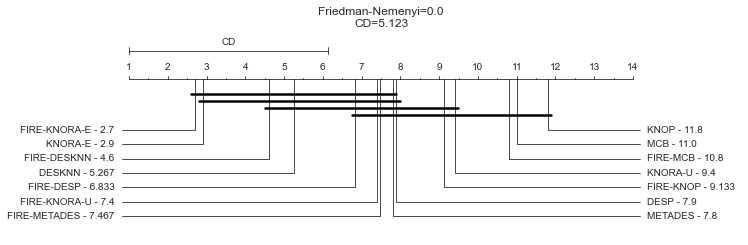

In [39]:
plot_comparisons(fried_result, names, cd, average_ranks)

In [40]:
names = ["FIRE-KNORA-U", "KNORA-U", "FIRE-KNORA-E", "KNORA-E", "FIRE-METADES", "METADES",
         "FIRE-DESKNN", "DESKNN", "FIRE-MCB", "MCB", "FIRE-DESP", "DESP", "FIRE-KNOP", "KNOP"]

accuracy_list = [] 

for n in names: 
    accuracy_list.append(fireResultsDF[fireResultsDF.name==n].accuracy.to_list())
    
results = {"models": names, 
           "accuracy": accuracy_list}

res = pd.DataFrame.from_dict(results)

In [41]:
res

,models,accuracy
0,FIRE-KNORA-U,"[0.9735706580366774, 0.9697950377562028, 0.974..."
1,KNORA-U,"[0.9719525350593312, 0.9681769147788565, 0.970..."
2,FIRE-KNORA-E,"[0.9805825242718447, 0.9795037756202805, 0.981..."
3,KNORA-E,"[0.9816612729234089, 0.9789644012944984, 0.980..."
4,FIRE-METADES,"[0.9811218985976268, 0.9406688241639698, 0.984..."
5,METADES,"[0.982740021574973, 0.9401294498381877, 0.9832..."
6,FIRE-DESKNN,"[0.9757281553398058, 0.9735706580366774, 0.977..."
7,DESKNN,"[0.9757281553398058, 0.9741100323624595, 0.976..."
8,FIRE-MCB,"[0.9487594390507011, 0.9563106796116505, 0.961..."
9,MCB,"[0.9644012944983819, 0.9579288025889967, 0.955..."


In [42]:
res.to_csv("Results/mix_pool_results/des_mix_pool_results_7_extend_for_CD.csv", index=False)